In [13]:
# Installation des librairies nécessaires (si non installées)
!pip install pandas numpy matplotlib seaborn 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Collecte des données
# On lit le fichier CSV (séparateur virgule ',' ou point-virgule ';' selon votre version)
try:
    df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv', sep=',')
    # Si le fichier est mal lu (tout dans une colonne), essayez sep=';'
    if df.shape[1] == 1:
        df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv', sep=';')
    print("Données chargées avec succès.")
except FileNotFoundError:
    print("Erreur : Fichier introuvable.")

Defaulting to user installation because normal site-packages is not writeable
Données chargées avec succès.


In [14]:
# 2. Inspection
print(f"Dimensions initiales : {df.shape}")
print("\nTypes des données :")
print(df.dtypes.value_counts()) # Résumé des types
print("\nAperçu des premières lignes :")
display(df.head())

Dimensions initiales : (1470, 35)

Types des données :
int64     26
object     9
Name: count, dtype: int64

Aperçu des premières lignes :


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [15]:
# 3. Nettoyage

# 3.1 Suppression des doublons
df = df.drop_duplicates()

# 3.2 Suppression des colonnes constantes (inutiles pour l'analyse)
colonnes_inutiles = ['EmployeeCount', 'Over18', 'StandardHours']
# On vérifie si elles existent avant de supprimer pour éviter les erreurs
cols_a_supprimer = [c for c in colonnes_inutiles if c in df.columns]
df_clean = df.drop(columns=cols_a_supprimer)

print(f"Colonnes supprimées : {cols_a_supprimer}")
print(f"Dimensions après nettoyage : {df_clean.shape}")

Colonnes supprimées : ['EmployeeCount', 'Over18', 'StandardHours']
Dimensions après nettoyage : (1470, 32)


In [16]:
# 3.3 Gestion des valeurs manquantes
if df_clean.isnull().sum().sum() > 0:
    print("Valeurs manquantes détectées. Remplissage...")
    df_clean = df_clean.fillna(method='ffill') # Ou remplissage par la moyenne/mode selon le cas
else:
    print("Aucune valeur manquante.")

# 3.4 Standardisation des formats (Texte)
# On met les colonnes texte au format Titre (ex: "travel_rarely" -> "Travel_Rarely")
cols_texte = df_clean.select_dtypes(include=['object']).columns
for col in cols_texte:
    df_clean[col] = df_clean[col].str.strip().str.title()

print("Formats standardisés.")

Aucune valeur manquante.
Formats standardisés.


In [17]:
# 3.5 Détection des Outliers sur le Salaire (MonthlyIncome)
Q1 = df_clean['MonthlyIncome'].quantile(0.25)
Q3 = df_clean['MonthlyIncome'].quantile(0.75)
IQR = Q3 - Q1

borne_inf = Q1 - 1.5 * IQR
borne_sup = Q3 + 1.5 * IQR

# On filtre (on garde ce qui est dans les bornes)
df_clean = df_clean[
    (df_clean['MonthlyIncome'] >= borne_inf) & 
    (df_clean['MonthlyIncome'] <= borne_sup)
].copy()

print(f"Dimensions après suppression des outliers de salaire : {df_clean.shape}")

Dimensions après suppression des outliers de salaire : (1356, 32)


In [18]:
# 4. Transformation

# Création de colonnes calculées (Ex: Revenu Annuel)
df_clean['AnnualIncome'] = df_clean['MonthlyIncome'] * 12

# Encodage de la variable cible 'Attrition' (Yes -> 1, No -> 0)
# C'est nécessaire pour la corrélation et la prédiction, mais on garde aussi la version texte si besoin
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_clean['Attrition_Numeric'] = le.fit_transform(df_clean['Attrition'])

print("Nouvelles colonnes ajoutées : AnnualIncome, Attrition_Numeric")

Nouvelles colonnes ajoutées : AnnualIncome, Attrition_Numeric


In [19]:
# 5. Structuration
# On définit l'identifiant unique comme index du tableau
if 'EmployeeNumber' in df_clean.columns:
    df_structure = df_clean.set_index('EmployeeNumber')
else:
    df_structure = df_clean

# On affiche la liste des colonnes disponibles pour confirmer qu'on a tout gardé
print("Colonnes disponibles pour vos analyses :")
print(df_structure.columns.tolist())
display(df_structure.head())

Colonnes disponibles pour vos analyses :
['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'AnnualIncome', 'Attrition_Numeric']


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,AnnualIncome,Attrition_Numeric
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,
1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,0,8,0,1,6,4,0,5,71916,1
2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,1,10,3,3,10,7,1,7,61560,0
4,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,0,7,3,3,0,0,0,0,25080,1
5,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,0,8,3,3,8,7,3,0,34908,0
7,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,1,6,3,3,2,2,2,2,41616,0


In [21]:
# 7. Stockage
nom_fichier = 'HR_Analytics_Structure_Complet.csv'
df_structure.to_csv(nom_fichier)
print(f"Fichier structuré et complet sauvegardé sous : {nom_fichier}")

Fichier structuré et complet sauvegardé sous : HR_Analytics_Structure_Complet.csv


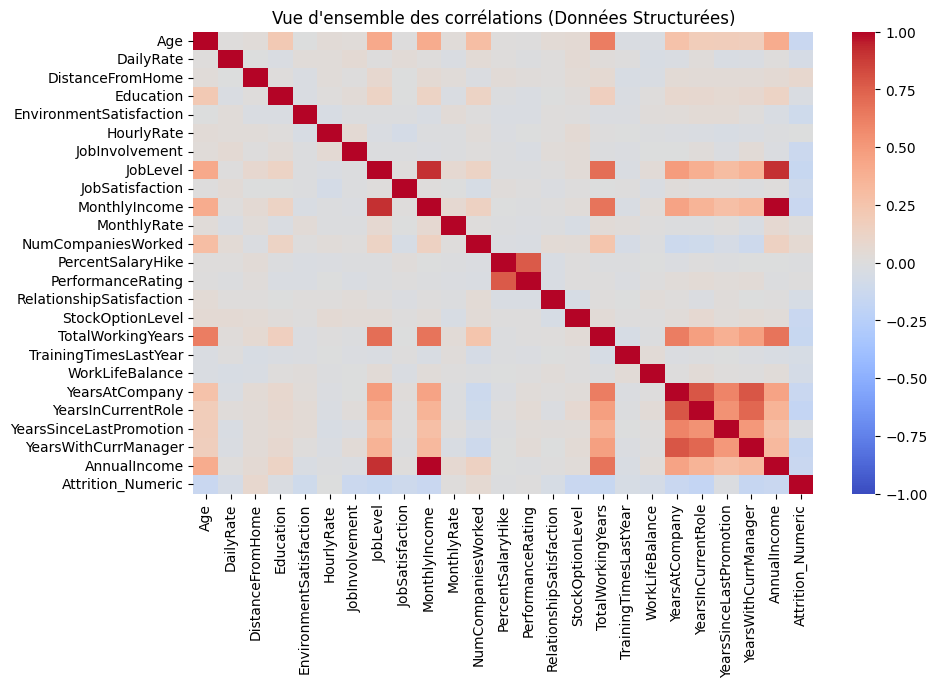

In [20]:
# 6. Vérification
plt.figure(figsize=(10, 6))
# Carte de corrélation (uniquement sur les valeurs numériques) pour voir les liens
sns.heatmap(df_structure.select_dtypes(include=np.number).corr(), cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Vue d'ensemble des corrélations (Données Structurées)")
plt.show()

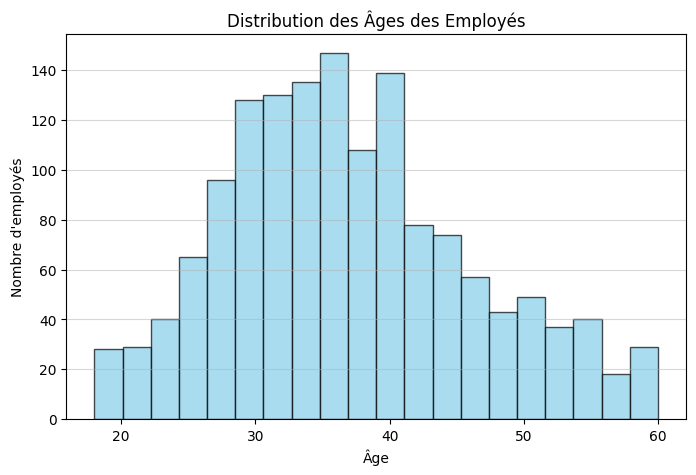

In [22]:
# --- 1. Histogramme (Matplotlib) ---
plt.figure(figsize=(8, 5))

# Création de l'histogramme de l'Âge
# bins=20 définit la granularité, alpha=0.7 la transparence [cite: 312]
plt.hist(df['Age'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# Ajout des titres et labels [cite: 318, 320, 323]
plt.title("Distribution des Âges des Employés")
plt.xlabel("Âge")
plt.ylabel("Nombre d'employés")
plt.grid(True, axis='y', alpha=0.5) # Grille pour la lisibilité [cite: 335]

plt.show()

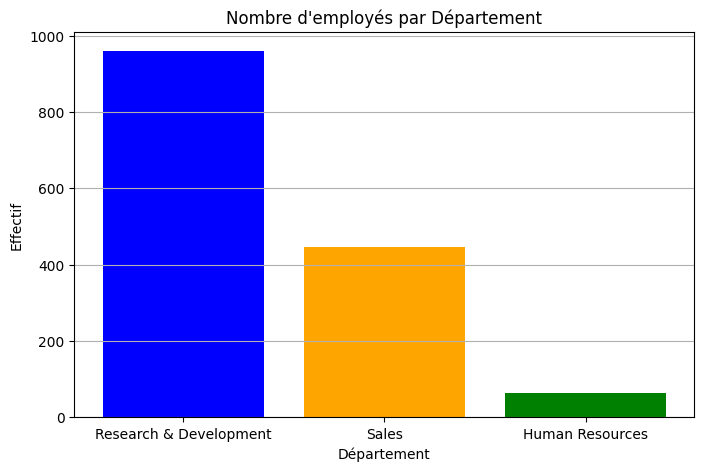

In [23]:
# --- 2. Diagramme en Barres Vertical (Matplotlib) ---
# Préparation des données : compte par département
dept_counts = df['Department'].value_counts()

plt.figure(figsize=(8, 5))
# Barres verticales [cite: 499]
plt.bar(dept_counts.index, dept_counts.values, color=['blue', 'orange', 'green'])

plt.title("Nombre d'employés par Département")
plt.xlabel("Département")
plt.ylabel("Effectif")
plt.grid(axis='y')

plt.show()

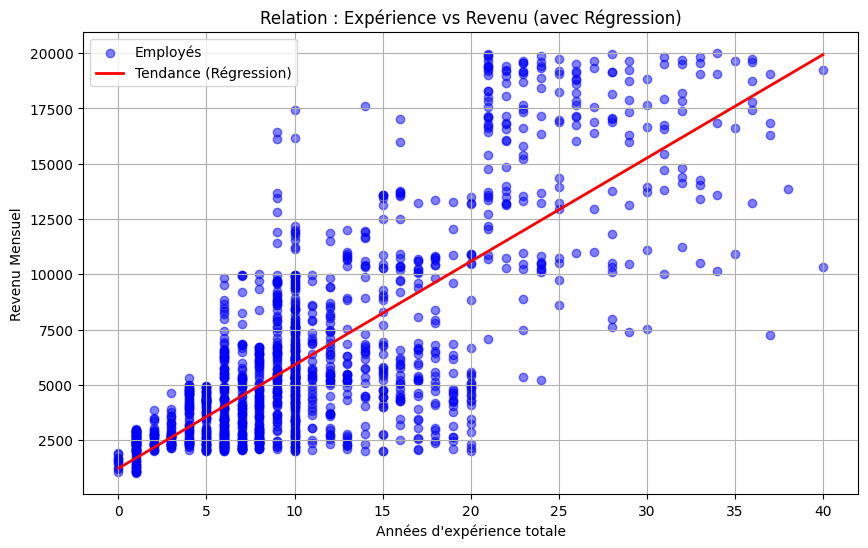

In [24]:
# --- 3. Scatter Plot 2D + Régression (Matplotlib) ---
plt.figure(figsize=(10, 6))

# Variables
x = df['TotalWorkingYears']
y = df['MonthlyIncome']

# Nuage de points [cite: 819]
plt.scatter(x, y, color='blue', alpha=0.5, label='Employés', marker='o')

# Calcul de la régression linéaire (droite de tendance) [cite: 934, 935]
# deg=1 signifie un polynôme de degré 1 (une droite)
coeffs = np.polyfit(x, y, deg=1)
droite = np.poly1d(coeffs)
x_vals = np.linspace(x.min(), x.max(), 100)

# Tracé de la ligne rouge [cite: 946]
plt.plot(x_vals, droite(x_vals), color='red', linewidth=2, label='Tendance (Régression)')

plt.title("Relation : Expérience vs Revenu (avec Régression)")
plt.xlabel("Années d'expérience totale")
plt.ylabel("Revenu Mensuel")
plt.legend()
plt.grid(True)

plt.show()

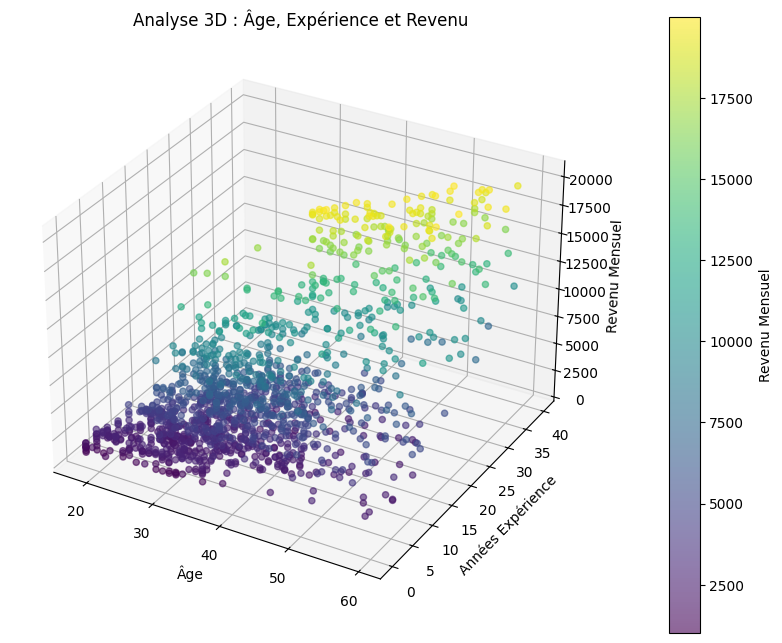

In [25]:
# --- 4. Scatter Plot 3D (Matplotlib) ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d') # Activation 3D [cite: 986]

# Variables
xs = df['Age']
ys = df['TotalWorkingYears']
zs = df['MonthlyIncome']

# Tracé 3D [cite: 987]
scatter = ax.scatter(xs, ys, zs, c=zs, cmap='viridis', marker='o', alpha=0.6)

# Labels des axes [cite: 989-991]
ax.set_xlabel('Âge')
ax.set_ylabel('Années Expérience')
ax.set_zlabel('Revenu Mensuel')
ax.set_title("Analyse 3D : Âge, Expérience et Revenu")

# Barre de couleur pour le revenu
plt.colorbar(scatter, ax=ax, label='Revenu Mensuel', pad=0.1)

plt.show()

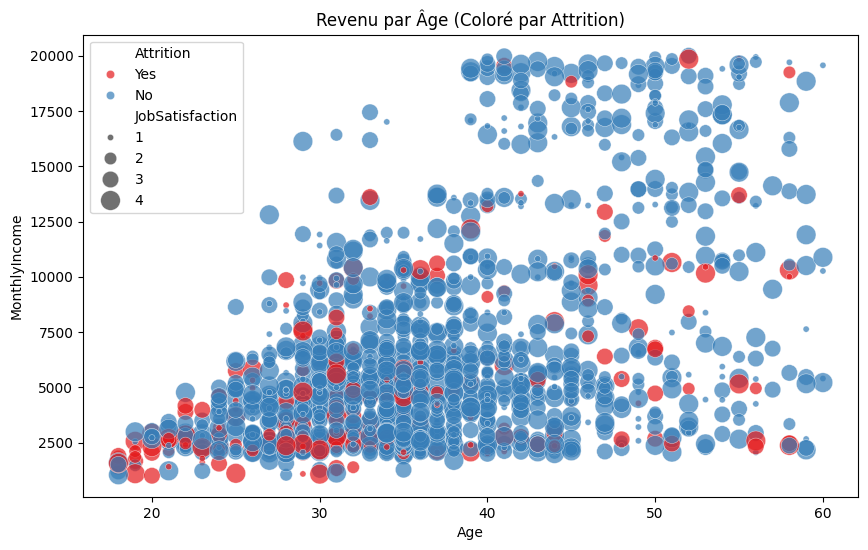

In [26]:
# --- 5. Scatterplot Avancé (Seaborn) ---
plt.figure(figsize=(10, 6))

# hue='Attrition' colore les points selon le départ (Oui/Non) [cite: 1752]
# size='JobSatisfaction' change la taille selon la satisfaction [cite: 1754]
sns.scatterplot(
    data=df,
    x='Age',
    y='MonthlyIncome',
    hue='Attrition',
    size='JobSatisfaction',
    sizes=(20, 200), # Taille min et max des points
    palette='Set1',  # Palette de couleurs [cite: 1755]
    alpha=0.7
)

plt.title("Revenu par Âge (Coloré par Attrition)")
plt.show()